<img src="../images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png" align="left"></img>

# wradlib time series data and quasi vertical profiles

---

## Overview

Within this notebook, we will cover:

1. Reading radar sweep timeseries data into xarray based RadarVolume
1. Examination of RadarVolume and Sweep
1. Calculation of Quasivertical Profiles and Plotting

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |
| [Xarray Plotting](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Plotting/Faceting |

- **Time to learn**: 7.5 minutes

---

## Imports

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm_notebook as tqdm

import wradlib as wrl
import xradar as xd

## Import Australian Radar Data

It is assumed, that data from IDR71 (Terrey Hills, Sidney) from 20th of December 2018 is used in this notebook.

In [2]:
fglob = "data/hdf5/terrey_*.h5"
idr71 = glob.glob(fglob)
idr71.sort()
print("Files available: {}".format(len(idr71)))

Files available: 40


## Single Quasi Vertical Profile (QVP)


In [3]:
odh = xd.io.open_odim_datatree(idr71[24])

In [4]:
display(odh)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2018-12-20T07:28:37Z'
│       time_coverage_end    <U20 '2018-12-20T07:28:47Z'
│       longitude            float64 151.2
│       altitude             float64 195.0
│       latitude             float64 -33.7
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 360, range: 200)
        Coordinates:
          * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
            elevation          (azimuth) float32 ...
            time               (azimuth) datetime64[ns] 2018-12-20T07:28:41.598600960...
          * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
            longitude          float64 ...
            latitude           float64 ...
            altitude           float64 ...
        Data variables: (12/13)
            DBZH               (azimuth, range) float32 ...
            VRADH              (azimuth, range) float32 ...
            WRADH              (azimuth, range) float32 ...
            TH                 (azimuth, range) float32 ...
            ZDR                (azimuth, range) float32 ...
            RHOHV              (azimuth, range) float32 ...
            ...                 ...
            SNRH               (azimuth, range) float32 ...
            sweep_mode         <U20 ...
            sweep_number       int64 ...
            prt_mode           <U7 ...
            follow_mode        <U7 ...
            sweep_fixed_angle  float64 ...

This example shows how to create a so called QVP. We need to define a function to add a height coordinate for plotting.

In [5]:
def add_height(ds):
    ds = ds.xradar.georeference()
    height = ds.z.mean("azimuth")
    ds = ds.assign_coords({"height": (["range"], height.data)})
    return ds

In [6]:
swp = odh["sweep_0"].ds.pipe(add_height)
display(swp)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 200)
Coordinates:
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 32.0 32.0 32.0 32.0 ... 32.0 32.0 32.0
    time               (azimuth) datetime64[ns] 2018-12-20T07:28:41.598600960...
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    longitude          float64 151.2
    latitude           float64 -33.7
    altitude           float64 195.0
    spatial_ref        int64 0
    x                  (azimuth, range) float32 0.925 2.775 ... -366.1 -368.0
    y                  (azimuth, range) float32 106.0 318.0 ... 4.216e+04
    z                  (azimuth, range) float32 262.0 395.0 ... 2.673e+04
    height             (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
Data variables: (12/13)
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    TH                 (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    ...                 ...
    SNRH               (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

Here we add the height coordinate and calculate the `mean` over the azimuth using the sweep with the highest available elevation.

In [7]:
qvp = swp["DBZH"].median("azimuth")
qvp

<xarray.DataArray 'DBZH' (range: 200)>
array([-1.5 , -1.5 ,  4.5 ,  7.  ,  7.5 ,  9.  , 11.  , 13.  , 15.25,
       17.  , 19.  , 21.75, 23.  , 25.5 , 24.5 , 25.  , 25.  , 25.  ,
       25.5 , 25.5 , 26.5 , 25.75, 24.75, 27.5 , 27.75, 29.  , 29.25,
       25.75, 27.  , 29.25, 30.  , 30.5 , 31.  , 30.5 , 29.5 , 28.5 ,
       29.5 , 29.25, 29.  , 28.5 , 28.  , 27.5 , 27.  , 27.5 , 28.5 ,
       27.25, 28.  , 29.  , 30.  , 29.5 , 29.5 , 29.  , 28.5 , 29.  ,
       28.5 , 28.25, 28.  , 28.5 , 29.  , 28.5 , 28.  , 28.5 , 28.5 ,
       28.  , 27.5 , 27.5 , 27.  , 26.5 , 26.5 , 26.  , 26.  , 25.5 ,
       25.  , 25.  , 24.75, 24.5 , 24.  , 23.75, 23.5 , 22.5 , 22.  ,
       22.  , 21.5 , 20.5 , 20.5 , 19.5 , 19.  , 18.25, 17.5 , 17.  ,
       16.  , 16.  , 15.  , 15.5 , 15.  , 14.  , 13.75, 12.5 , 12.  ,
       12.  , 11.5 , 10.5 , 10.  ,  9.  ,  8.5 ,  7.  ,  5.5 ,  3.5 ,
        3.75,  3.5 ,  3.  ,  1.5 ,  1.5 ,  1.  ,  0.5 ,  1.5 ,  1.5 ,
        2.  ,  0.5 ,  1.  ,  0.  ,  0.  ,  1.  ,  1.25, -0.5 , -2.  ,
       -1.25, -2.  , -1.  , -1.5 , -2.  , -2.5 , -2.  , -1.5 , -1.5 ,
        0.  , -1.  , -2.5 , -3.  , -5.5 , -4.  ,  1.5 , -0.5 , -2.5 ,
        1.  ,  2.  ,  1.  , -0.5 ,   nan,   nan,   nan, -1.75, -5.  ,
       -4.5 , -2.  , -1.25, -4.5 ,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan], dtype=float32)
Coordinates:
  * range        (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    longitude    float64 151.2
    latitude     float64 -33.7
    altitude     float64 195.0
    spatial_ref  int64 0
    height       (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04

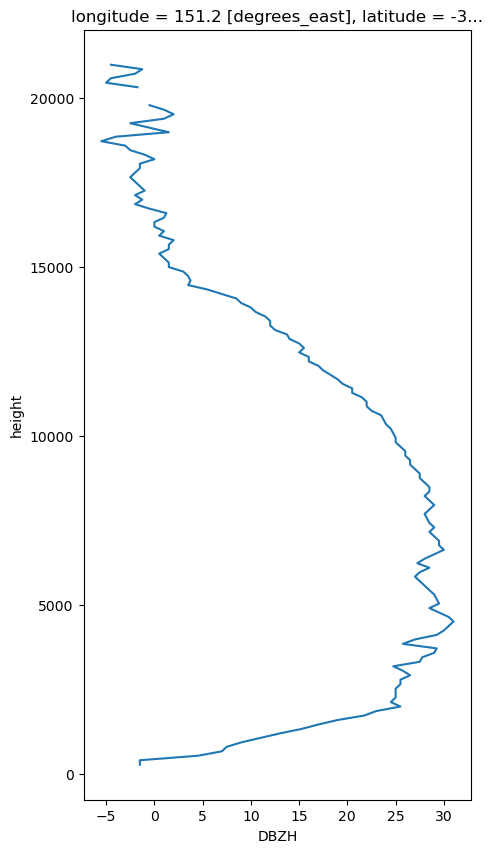

In [8]:
qvp.plot(y="height", figsize=(5, 10))

## TimeSeries QVP

All wradlib xarray backends have the capability to read multiple sweeps/volumes in one go. We have to prepare the list of files a bit, though.

In [9]:
ts = xr.open_mfdataset(
    idr71,
    engine="odim",
    group="sweep_0",
    combine="nested",
    first_dim='auto',
    concat_dim="volume_time",
)

In [10]:
ts["volume_time"] = ts.time.mean('azimuth').compute()

In [11]:
display(ts)

<xarray.Dataset>
Dimensions:            (volume_time: 40, azimuth: 360, range: 200)
Coordinates:
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    time               (volume_time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    longitude          float64 151.2
    latitude           float64 -33.7
    altitude           float64 195.0
  * volume_time        (volume_time) datetime64[ns] 2018-12-20T05:04:37.49998...
Data variables: (12/13)
    DBZH               (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    VRADH              (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    WRADH              (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    TH                 (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ZDR                (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    RHOHV              (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ...                 ...
    SNRH               (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    sweep_mode         (volume_time) <U20 'azimuth_surveillance' ... 'azimuth...
    sweep_number       (volume_time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    prt_mode           (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
    follow_mode        (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
    sweep_fixed_angle  (volume_time) float64 32.0 32.0 32.0 ... 32.0 32.0 32.0

### Georeference and add height coordinate

In [12]:
ts = ts.pipe(add_height)
display(ts)

<xarray.Dataset>
Dimensions:            (volume_time: 40, azimuth: 360, range: 200)
Coordinates: (12/13)
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    time               (volume_time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    longitude          float64 151.2
    latitude           float64 -33.7
    ...                 ...
  * volume_time        (volume_time) datetime64[ns] 2018-12-20T05:04:37.49998...
    spatial_ref        int64 0
    x                  (azimuth, range) float32 dask.array<chunksize=(360, 200), meta=np.ndarray>
    y                  (azimuth, range) float32 dask.array<chunksize=(360, 200), meta=np.ndarray>
    z                  (azimuth, range) float32 dask.array<chunksize=(360, 200), meta=np.ndarray>
    height             (range) float32 dask.array<chunksize=(200,), meta=np.ndarray>
Data variables: (12/13)
    DBZH               (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    VRADH              (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    WRADH              (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    TH                 (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ZDR                (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    RHOHV              (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ...                 ...
    SNRH               (volume_time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    sweep_mode         (volume_time) <U20 'azimuth_surveillance' ... 'azimuth...
    sweep_number       (volume_time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    prt_mode           (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
    follow_mode        (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
    sweep_fixed_angle  (volume_time) float64 32.0 32.0 32.0 ... 32.0 32.0 32.0

### Calculate Statistics

In [13]:
stats = ["median", "mean", "min", "max"]
stat = [
    getattr(ts.where(ts.RHOHV > 0.8), st)("azimuth", skipna=True, keep_attrs=True)
    for st in stats
]
ts_stats = xr.concat(stat, dim="stats")
ts_stats = ts_stats.assign_coords({"stats": stats})

In [14]:
display(ts_stats)

<xarray.Dataset>
Dimensions:            (stats: 4, volume_time: 40, range: 200)
Coordinates:
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    longitude          float64 151.2
    latitude           float64 -33.7
    altitude           float64 195.0
  * volume_time        (volume_time) datetime64[ns] 2018-12-20T05:04:37.49998...
    spatial_ref        int64 0
    height             (range) float32 dask.array<chunksize=(200,), meta=np.ndarray>
  * stats              (stats) <U6 'median' 'mean' 'min' 'max'
Data variables: (12/13)
    DBZH               (stats, volume_time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    VRADH              (stats, volume_time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    WRADH              (stats, volume_time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    TH                 (stats, volume_time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    ZDR                (stats, volume_time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    RHOHV              (stats, volume_time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    ...                 ...
    SNRH               (stats, volume_time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    sweep_number       (stats, volume_time, range) float64 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    sweep_fixed_angle  (stats, volume_time, range) float64 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    sweep_mode         (stats, volume_time, range) object dask.array<chunksize=(3, 1, 200), meta=np.ndarray>
    prt_mode           (stats, volume_time, range) object dask.array<chunksize=(3, 1, 200), meta=np.ndarray>
    follow_mode        (stats, volume_time, range) object dask.array<chunksize=(3, 1, 200), meta=np.ndarray>

### Plot QVP's

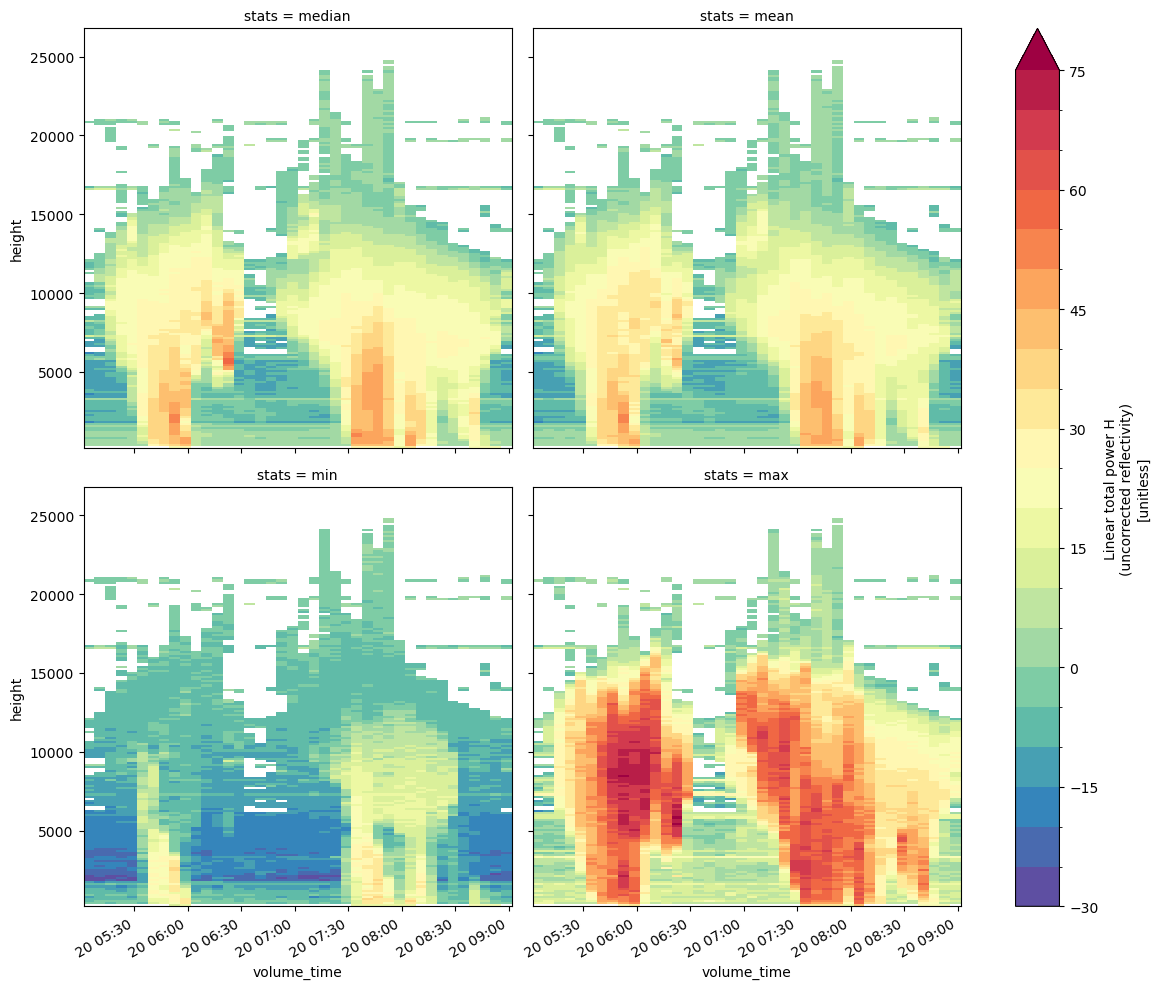

In [16]:
levels = np.arange(-30, 80, 5)
facet = ts_stats.TH.plot(
    x="volume_time",
    y="height",
    col="stats",
    col_wrap=2,
    cmap="Spectral_r",
    figsize=(12, 10),
    levels=levels
)

---

## Summary
Easy creation of Quasi Vertical Profiles was shown.


## Resources and references

- [xarray](https://docs.xarray.dev)
- [dask](https://docs.dask.org/)
- [wradlib xarray backends](https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_backends.html)
- [OPERA ODIM_H5](https://www.eumetnet.eu/activities/observations-programme/current-activities/opera/)
- [WMO JET-OWR](https://community.wmo.int/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom/commission-infrastructure-officers/infcom-management-group/standing-committee-measurements-instrumentation-and-traceability-sc-mint/joint-expert-team)